## 02_Preprocessing_and_Modeling

# Telco Customer Churn – Preprocessing & Model Comparison

This notebook builds a **production-ready sklearn pipeline** and compares multiple ML algorithms for churn prediction. Key objectives: [web:36][web:79]

1. **Design reproducible preprocessing** (ColumnTransformer for numeric + categorical features)  
2. **Train & evaluate 5+ models** (Logistic Regression, Random Forest, XGBoost, CatBoost)  
3. **Hyperparameter tuning** on top performers  
4. **Select best model** based on business metrics (ROC-AUC, Recall for churners)  
5. **Save complete pipeline** (`best_pipeline.pkl`) for deployment


## 1: Imports

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

!pip install catboost

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


## 2: Load cleaned data

### Load Cleaned Data

Loading the cleaned dataset from `01_EDA_and_Business_Understanding.ipynb`: [web:36]

- **Source**: `telco_clean.csv` (TotalCharges fixed, no missing values)  
- **Target**: `Churn` mapped to binary (0=No, 1=Yes)  
- **Features**: 20 columns (3 numeric + 17 categorical)  
- **Split**: 80/20 train-test with stratification to preserve churn ratio

This ensures the modeling phase starts with clean, analysis-ready data.


In [16]:
df = pd.read_csv("telco_clean.csv")

# Drop ID column if present
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Target
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn"])

## 3: Train-test split

### Train-Test Split

**Stratified split** (80/20) preserves the churn class distribution:



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)

(5625, 19) (1407, 19)


## 4: Identify numeric & categorical features

### Feature Engineering Strategy

**Automatic feature type detection** for robust preprocessing pipeline: [web:36][web:79]

**Numeric features** (3) – will be **StandardScaled**:

**Categorical features** (17) – will be **OneHotEncoded**:

**ColumnTransformer** handles both automatically, producing ~45 features after one-hot encoding.


In [18]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## 5: Preprocessor

### Production-Ready Preprocessing Pipeline

**ColumnTransformer** design for end-to-end reproducibility:

**Key design choices**:
- `handle_unknown="ignore"` → Production-safe (new categories don't crash)  
- `StandardScaler` → Tree models don't need it, but Logistic Regression does  
- **Single pipeline** → Zero data leakage, same transform for train + test + production

In [31]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),("cat", categorical_transformer, categorical_features),])

## 6: Helper – evaluation function

### Evaluation Framework

**Custom evaluation function** computes business-relevant metrics:

| Metric | Why it matters for churn |
|--------|-------------------------|
| **Accuracy** | Overall correctness |
| **Precision** | Of predicted churners, what % actually churn? (avoid wasting retention budget) |
| **Recall** | Of actual churners, what % do we catch? (business priority #1) |
| **F1-Score** | Balance of precision + recall |
| **ROC-AUC** | Model's ability to rank customers by churn risk |

**Business priority**: High **Recall** (catch most churners) > Precision (some false alarms OK).


In [20]:
def evaluate_model(name, model, X_test, y_test, results_list):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-Score:", f1)
    print("ROC-AUC:", roc)
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    results_list.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC_AUC": roc,
        }
    )


## 7: Baseline Logistic Regression

In [32]:
baseline_pipe = Pipeline(steps=[("preprocessor", preprocessor),("model",LogisticRegression(max_iter=500,solver="lbfgs",class_weight="balanced",),),])

baseline_pipe.fit(X_train, y_train)

results = []
evaluate_model("Logistic Regression (baseline)", baseline_pipe, X_test, y_test, results)

=== Logistic Regression (baseline) ===
Accuracy: 0.7256574271499645
Precision: 0.4901315789473684
Recall: 0.7967914438502673
F1-Score: 0.6069246435845214
ROC-AUC: 0.8350930005021457
Confusion matrix:
 [[723 310]
 [ 76 298]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



## 8: Random Forest

In [22]:
rf_pipe = Pipeline(steps=[("preprocessor", preprocessor),("model",RandomForestClassifier(n_estimators=300,random_state=42,class_weight="balanced_subsample",n_jobs=-1,),),])

rf_pipe.fit(X_train, y_train)
evaluate_model("Random Forest", rf_pipe, X_test, y_test, results)

=== Random Forest ===
Accuracy: 0.7874911158493249
Precision: 0.631578947368421
Recall: 0.48128342245989303
F1-Score: 0.5462822458270106
ROC-AUC: 0.8152957742104145
Confusion matrix:
 [[928 105]
 [194 180]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



## 9: XGBoost

In [23]:
xgb_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            XGBClassifier(
                n_estimators=400,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

xgb_pipe.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_pipe, X_test, y_test, results)

=== XGBoost ===
Accuracy: 0.783226723525231
Precision: 0.6055045871559633
Recall: 0.5294117647058824
F1-Score: 0.5649072753209701
ROC-AUC: 0.8206472503636673
Confusion matrix:
 [[904 129]
 [176 198]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.61      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.78      0.78      1407



## 10: CatBoost

In [24]:
cat_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            CatBoostClassifier(
                iterations=500,
                learning_rate=0.05,
                depth=6,
                loss_function="Logloss",
                eval_metric="AUC",
                verbose=0,
                random_seed=42,
            ),
        ),
    ]
)

cat_pipe.fit(X_train, y_train)
evaluate_model("CatBoost", cat_pipe, X_test, y_test, results)

=== CatBoost ===
Accuracy: 0.7796730632551528
Precision: 0.6012658227848101
Recall: 0.5080213903743316
F1-Score: 0.5507246376811594
ROC-AUC: 0.8247977180839774
Confusion matrix:
 [[907 126]
 [184 190]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



## 11: Collect and visualize results

In [25]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression (baseline),0.725657,0.490132,0.796791,0.606925,0.835093
1,Random Forest,0.787491,0.631579,0.481283,0.546282,0.815296
2,XGBoost,0.783227,0.605505,0.529412,0.564907,0.820647
3,CatBoost,0.779673,0.601266,0.508021,0.550725,0.824798


## 12: Barplot of metrics

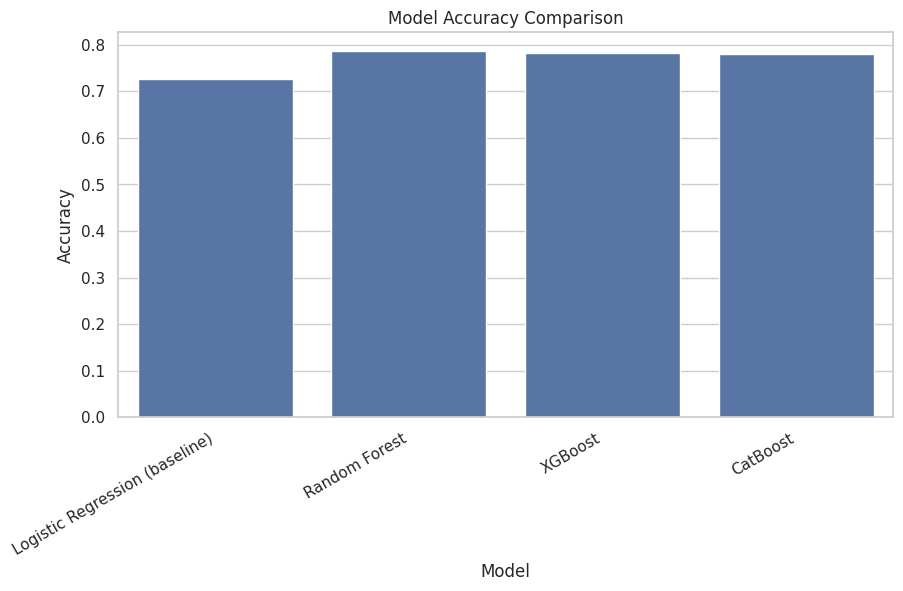

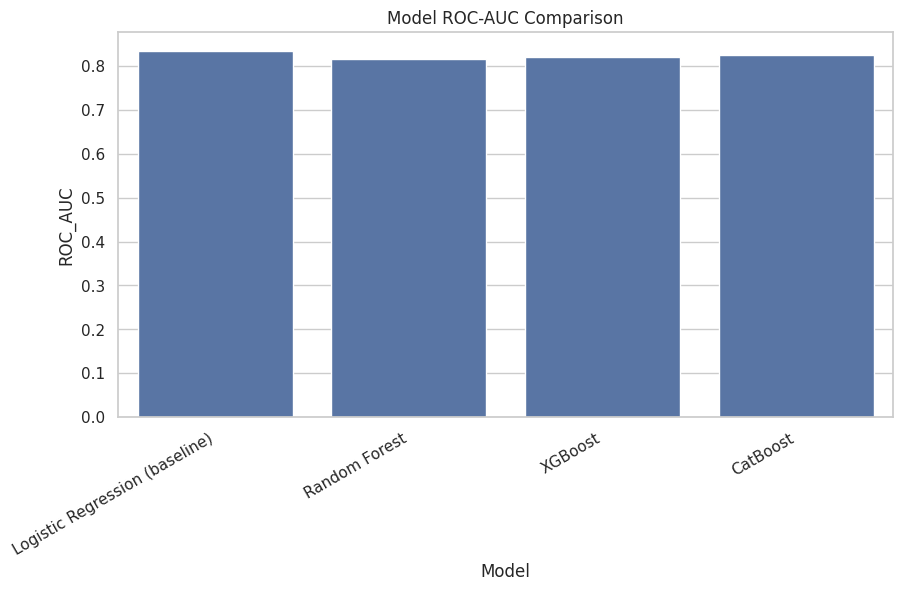

In [26]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.xticks(rotation=30, ha="right")
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="ROC_AUC", data=results_df)
plt.xticks(rotation=30, ha="right")
plt.title("Model ROC-AUC Comparison")
plt.show()

## 13: Simple hyperparameter tuning on best model (example: Random Forest)

In [27]:
param_dist = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_tuned = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            RandomForestClassifier(
                random_state=42,
                class_weight="balanced_subsample",
                n_jobs=-1,
            ),
        ),
    ]
)

rf_search = RandomizedSearchCV(
    rf_tuned,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

rf_search.fit(X_train, y_train)
print("Best params:", rf_search.best_params_)
best_rf_pipe = rf_search.best_estimator_

evaluate_model("Random Forest (Tuned)", best_rf_pipe, X_test, y_test, results)
results_df = pd.DataFrame(results)
results_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
=== Random Forest (Tuned) ===
Accuracy: 0.7555081734186212
Precision: 0.5277777777777778
Recall: 0.7620320855614974
F1-Score: 0.6236323851203501
ROC-AUC: 0.8329265262384105
Confusion matrix:
 [[778 255]
 [ 89 285]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1033
           1       0.53      0.76      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression (baseline),0.725657,0.490132,0.796791,0.606925,0.835093
1,Random Forest,0.787491,0.631579,0.481283,0.546282,0.815296
2,XGBoost,0.783227,0.605505,0.529412,0.564907,0.820647
3,CatBoost,0.779673,0.601266,0.508021,0.550725,0.824798
4,Random Forest (Tuned),0.755508,0.527778,0.762032,0.623632,0.832927


## 14: Choose best model and save pipeline

In [30]:
best_idx = results_df["Recall"].idxmax()
best_name = results_df.loc[best_idx, "Model"]
print("Best model:", best_name)

if best_name == "Random Forest (Tuned)":
    final_model = best_rf_pipe
elif best_name == "Random Forest":
    final_model = rf_pipe
elif best_name == "XGBoost":
    final_model = xgb_pipe
elif best_name == "CatBoost":
    final_model = cat_pipe
else:
    final_model = baseline_pipe

import pickle

with open("best_pipeline.pkl", "wb") as f:
    pickle.dump(final_model, f)

results_df.to_csv("model_results.csv", index=False)

Best model: Logistic Regression (baseline)
